In [1]:
import os
import sys
os.chdir('../')
new_current_dir = os.getcwd()  # get new current working directory
print("New current directory:", new_current_dir)
sys.path.append('./src/python/')

# import
from preamble.preamble import *
from gamma.gamma import GammaNPP
from gamma.rules import make_rules, Rules, readable_rules
from gamma.common import npp_from_json, set_of_frozenset
from plot.plot_function import *

New current directory: /home/fiftyfour/Documents/NetworkPricingGraphContraction


In [2]:
with open('./tmp/result/result_original.pkl', 'rb') as f:
    original_result = pickle.load(f)

In [3]:
cols_header = list(original_result['g30-01'].keys())
print(cols_header)
cols_header.remove('edge')
rows_header = list(original_result.keys())

original_meta_data = [
                [r[k] for k in cols_header] for r in original_result.values()
            ]
original_meta_data = pd.DataFrame(original_meta_data, index=rows_header,columns=cols_header)
original_meta_data['finish'] = original_meta_data['finish'].astype(bool)
original_meta_data['finish'] = original_meta_data['finish'].astype(int)

# tmp = meta_data_df[(meta_data_df['finish']==1) & (meta_data_df['solve_time']<=float(1000))]
# Creating a config for the server
# config = {}
# for pb_name, row in tmp.iterrows():
#     sh_time_limit = int(round(row['solve_time'] + 100,0)) # sec
#     config[pb_name] = sh_time_limit

# with open('./result/time_limit_config.pkl', 'wb') as f:
#     pickle.dump(config, f)

['edge', 'obj_value', 'preprocess_time', 'solve_time', 'n_vertex', 'n_edge', 'n_tolled', 'finish', 'n', 'min_sl', 'max_sl', 'm', 'H1', 'H2', 'H3', 'H4', 'max_attemp', 'option', 'heuristic', 'cf1', 'cf2', 'cf3', 'cf4', 'cf5', 'cf6', 'cf7', 'cf8', 'cf9']


In [4]:
# data on one problem
# ./data/generated/problems/paper/original/000000-000000-g50-09-R.json a un problem
# 'g30-07', g45-06 pas la
pb_list = [
            'g45-03', 'g45-04', 'g30-08', 'g35-03', 'g30-10', 'g50-08', 'g45-10', 'g30-03', 'g45-02',
            'g35-07', 'g35-05', 'g50-02', 'g40-05', 'g35-06', 'g50-06', 'g30-02', 'g45-09', 'g35-09',
            'g50-10', 'g45-07', 'g40-10', 'g50-07', 'g40-01', 'g35-02', 'g35-04', 'g45-01', 'g45-05', 'g30-04',
            'g45-08', 'g50-03', 'g30-05', 'g40-08', 'g30-01', 'g40-03', 'g40-04', 'g40-02', 'g35-10',
            'g30-06', 'g50-01', 'g35-08', 'g35-01', 'g30-09', 'g40-09', 'g40-07', 'g50-05', 'g50-04', 'g40-06',
]
    
    
result_dict = {}
for problem_name in pb_list:
    o_idx = f'000000-000000-0-0-0-0-0-0-0-0-0-{problem_name}'
    result = {}
    with open(f'./tmp/result/result_{problem_name}.pkl', 'rb') as f:
        result[o_idx] = original_result[problem_name]
        result.update(pickle.load(f))
        
    rows_header = list(map(lambda x: x[0], result[o_idx]['edge']))
    cols_header = list(result.keys())
    edge_index_data = [      
                        [ r['edge'][i][1] for r in result.values() ] 
                        for i,_ in enumerate(rows_header)   
                    ]
    edge_value_data = [      
                        [ r['edge'][i][2] for r in result.values() ] 
                        for i,_ in enumerate(rows_header)   
                    ]
    
    flow_value_data = [      
                        [ r['edge'][i][3] for r in result.values() ] 
                        for i,_ in enumerate(rows_header)   
                    ]
    # Table of the form
    #  edge v1 v2 v3 v4 ....
    #   e1  o11
    #   e2  o21
    #   e3  ...
    # ....
    edge_index_df = pd.DataFrame(edge_index_data, index = rows_header, columns=cols_header)
    edge_value_df = pd.DataFrame(edge_value_data, index = rows_header, columns=cols_header)
    flow_value_df = pd.DataFrame(flow_value_data, index = rows_header, columns=cols_header)
    
    
    ## meta_data
    # df of the form
    #  pb v1 v2 v3 v4 ....
    #   p1  o11
    #   p2  o21
    #   p3  ...
    # ....
    cols_header = list(result[o_idx].keys())
    cols_header.remove('edge')
    rows_header = list(result.keys())
    
    meta_data = [
                    [r[k] for k in cols_header] for r in result.values()
                ]
    meta_data_df = pd.DataFrame(meta_data, index=rows_header,columns=cols_header)
    meta_data_df[['min_sl', 'max_sl', 'm', 'H4']] = meta_data_df[['min_sl', 'max_sl', 'm', 'H4']].astype(int)
    meta_data_df['finish'] = meta_data_df['finish'].astype(bool)
    meta_data_df['finish'] = meta_data_df['finish'].astype(int)

    
    o_obj = meta_data_df['obj_value'][o_idx]
    o_time = meta_data_df['solve_time'][o_idx]
    o_n_tolled = meta_data_df['n_tolled'][o_idx]

    # Ratio of optimal
    meta_data_df['optimal_ratio'] = meta_data_df['obj_value']/o_obj
    # Absolute error
    meta_data_df['AE']  = abs(meta_data_df['obj_value'] - o_obj)
    # Relative error
    meta_data_df['RE'] = (meta_data_df['obj_value'] - o_obj)/o_obj

    meta_data_df['time_ratio'] = meta_data_df['solve_time']/o_time
    meta_data_df['adjusted_time'] = meta_data_df['solve_time']

    remove_rows = []
    for index, row in meta_data_df.iterrows():
        if (index != o_idx) and (not 'x' in index):
            oid = index[:-1] + 'x'
        
            if oid in meta_data_df.index:
                # print(row['adjusted_time'])
                # print(meta_data_df.loc[oid, 'solve_time'])
                # print('---')
            
                # row['adjusted_time'] += meta_data_df.loc[oid, 'solve_time']
                meta_data_df.loc[index, 'adjusted_time'] = row['adjusted_time']+meta_data_df.loc[oid, 'solve_time']
                # input(row['adjusted_time'])
        else:
            if not 'x' in index:
                remove_rows.append(index)

    meta_data_df.drop(remove_rows, inplace=True)
    meta_data_df['adjusted_time_ratio'] = meta_data_df['adjusted_time']/o_time
    
    meta_data_df['tolled_ratio'] = meta_data_df['n_tolled']/o_n_tolled

    # edge value
    col1 = edge_value_df.iloc[0:,0]
    col2 = edge_value_df.iloc[:, 1:].mean(axis=1)
    
    result = col2-col1
    meta_data_df['edge_diff_mean'] = result.mean() 
    meta_data_df['edge_diff_std'] = result.std()


    # flow value
    col1 = flow_value_df.iloc[0:,0]
    col2 = flow_value_df.iloc[:, 1:].mean(axis=1)
    
    result = (col2 - col1)    
    meta_data_df['flow_diff_mean'] = result.mean() 
    meta_data_df['flow_diff_std'] = result.std()

    columns = ['min_sl', 'max_sl', 'm', 'H4', 'option', 'heuristic']
    # parameter class
    meta_data_df['Class'] = meta_data_df[columns[:-2:]].astype(str).apply('-'.join, axis=1)
    
    meta_data_df['Class1'] = meta_data_df[columns[-3:]].astype(str).apply('-'.join, axis=1)
    # paramater + hyperparameter class
    meta_data_df['Class2'] = meta_data_df[columns].astype(str).apply('-'.join, axis=1)
    # paramater + hyperparameter + problem name class
    meta_data_df['Class3'] = meta_data_df['Class2'].astype(str) + f'-{problem_name}'
    # hyperparameter + problem name class
    meta_data_df['Class4'] = meta_data_df[columns[-2::]].astype(str).apply('-'.join, axis=1) + f'-{problem_name}'

    meta_data_df['pb_name'] = problem_name
    
    result_dict[problem_name] = {
                                'edge_index_df':edge_index_df.copy(),
                                'edge_value_df':edge_value_df.copy(),
                                'flow_value_df':flow_value_df.copy(),
                                'meta_data_df':meta_data_df.copy()
    }



merged_df = pd.DataFrame()
for pb_name in result_dict:
    merged_df = pd.concat([merged_df, result_dict[pb_name]['meta_data_df']])
merged_df = merged_df.T.filter(regex=r'^(?!000000-000000-0-0-0-0-0-0-0-0-0-.*).*$').T

## Balancing data parameter+hyperparameter+problem name
# Split the dataset into groups by class combination
grouped_df = merged_df.groupby('Class3')

# Determine the number of instances to select from each group
# (the smallest number of instances of any class combination)
n_instances = min(grouped_df.size())

# Extract a balanced subset of the dataset
balanced_df = pd.concat([grouped_df.get_group(cls).sample(n=n_instances, random_state=42) for cls in grouped_df.groups])



result_dict['combined'] = {
                            'edge_index_df':None,
                            'edge_value_df':None,
                            'flow_value_df':None,
                            'meta_data_df':merged_df.copy(),
                            'balanced_df':balanced_df.copy()
                        }

with open('compile_data.pkl', 'wb') as f:
    pickle.dump(result_dict, f)

In [12]:
# result_dict['g30-01']['edge_index_df']
# result_dict['g30-01']['edge_value_df']
# result_dict['g30-01']['flow_value_df']
# result_dict['g30-01']['meta_data_df']
# result_dict['combined']['meta_data_df'].loc[:, ['solve_time', 'adjusted_time']]
# result_dict['g30-01']['meta_data_df'].columns
# result_dict['combined']['meta_data_df']['option'].unique()
result_dict['combined']['meta_data_df']['heuristic'].unique()
# result_dict['combined']['meta_data_df'].columns


['option', 'heuristic']

In [2]:
with open('./compile_data.pkl', 'rb') as f:
    result_dict = pickle.load(f)

In [7]:
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.cm as cmx

df = result_dict['combined']['balanced_df']
### Color classes

### Class
class_labels = df['Class'].unique()
cmap = plt.colormaps['viridis']  # Use the 'viridis' colormap
n_colors = len(class_labels)
colors = [cmap(i/n_colors) for i in range(n_colors)]
class_color_map = dict(zip(class_labels, colors))

### Option
option_labels = df['option'].unique()
cmap = plt.colormaps['viridis']  # Use the 'viridis' colormap
n_colors = len(option_labels)
colors = [cmap(i/n_colors) for i in range(n_colors)]
option_color_map = dict(zip(option_labels, colors))

### Heuristic
heuristic_labels = df['heuristic'].unique()
cmap = plt.colormaps['viridis']  # Use the 'viridis' colormap
n_colors = len(heuristic_labels)
colors = [cmap(i/n_colors) for i in range(n_colors)]
heuristic_color_map = dict(zip(heuristic_labels, colors))

### Problem
problem_labels = df['pb_name'].unique()
cmap = plt.colormaps['viridis']  # Use the 'viridis' colormap
n_colors = len(problem_labels)
colors = [cmap(i/n_colors) for i in range(n_colors)]
problem_color_map = dict(zip(problem_labels, colors))

In [11]:
### Quadrant plot:
### quadrant 1 : Parameter Distribution
### quadrant 2 : Option Distribution
### quadrant 3 : Heuristic Distribution
### quadrant 4 : Problem Distribution


### The purpose is to look for a tendency when the optimal ratio is high
### Don't be fool by randomness
### Every transformation for each problem was randomly generated



df = result_dict['combined']['balanced_df']

for h4 in [0, 1]:
    for opt_r in [0.50, 0.70, 0.90, 0.95, 0.97]:

        conditions = [
            (df['m']!=0),                   # The number of equivalence classes 
            (df['max_sl']<=5),              # Maximum length one equivalence class can have
            (df['max_sl']>=2),              # Maximum length one equivalence class can have (0 mean arbitrary, so whe need a lower limit)
            (df['H4']==h4),                 # Contiguous hypothesis (1 or 0)
            (df['min_sl']>=2),              # Minimum length one none trivial equivalence class can have
            (df['heuristic']!='x'),         # Heuristic (1-2-3-4-5-x) (x is in the transformed space)
            (df['max_sl']==df['min_sl']),
        ]
        
        
        data_df = df[np.logical_and.reduce(conditions)]
        total_element = len(data_df)
        
        conditions.append(df['optimal_ratio']>=opt_r)   # Optimal ratio
        
        data_df = df[np.logical_and.reduce(conditions)]
        number_of_element = len(data_df)
        # print(f"Optimal ratio :{opt_r}, H4:{h4}")
        # print(f"Number of element\t: {number_of_element}")
        # print(f"Total number of element\t: {total_element}")
        
        # Create the subplots
        fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(35, 10))
        fig.subplots_adjust(left=0, right=0.95, bottom=0, top=1, wspace=0, hspace=0)
        
        
        # Plot 1 - Parameter Distribution when optimal ratio is over x%
        fracs = data_df['Class'].value_counts(normalize=True)
        mask = fracs > 0.01
        labels = fracs.index[mask].tolist()
        sizes = fracs[mask].tolist()
        
        # Add a category for classes less than 0.01
        mask_less_than_001 = fracs <= 0.01
        if mask_less_than_001.any():
            num_others = mask_less_than_001.sum()
            class_color_map[f'Others ({num_others})'] = 'gray'
            labels.append(f'Others ({num_others})')
            sizes.append(fracs[mask_less_than_001].sum())
        
        colors = [class_color_map[label] for label in labels]
        axs[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14}, rotatelabels=True, pctdistance=0.85, labeldistance=1.05)
        axs[0].set_title('Parameter Distribution', fontsize=20, y=1.05)
        ####################################################################
        ####################################################################
        
        
        # Plot 2 - Option Distribution when optimal ratio is over x%
        fracs = data_df['option'].value_counts(normalize=True)
        mask = fracs > 0.0005
        labels = fracs.index[mask].tolist()
        sizes = fracs[mask].tolist()
        
        # Add a category for options less than 0.0005
        mask_less_than_0005 = fracs <= 0.0005
        if mask_less_than_0005.any():
            num_others = mask_less_than_0005.sum()
            option_color_map[f'Others ({num_others})'] = 'gray'
            labels.append(f'Others ({num_others})')
            sizes.append(fracs[mask_less_than_0005].sum())
        
        colors = [option_color_map[label] for label in labels]
        axs[1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14}, rotatelabels=False, pctdistance=0.85, labeldistance=1.05)
        axs[1].set_title('Option Distribution', fontsize=20, y=1.05)
        ####################################################################
        ####################################################################
        
        
        # Plot 3 - Heuristic Distribution when optimal ratio is over x%
        fracs = data_df['heuristic'].value_counts(normalize=True)
        mask = fracs > 0.01
        labels = fracs.index[mask].tolist()
        sizes = fracs[mask].tolist()
        
        # Add a category for heuristics less than 0.01
        mask_less_than_001 = fracs <= 0.01
        if mask_less_than_001.any():
            num_others = mask_less_than_001.sum()
            heuristic_color_map[f'Others ({num_others})'] = 'gray'
            labels.append(f'Others ({num_others})')
            sizes.append(fracs[mask_less_than_001].sum())
        
        colors = [heuristic_color_map[label] for label in labels]
        axs[2].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14}, rotatelabels=False, pctdistance=0.85, labeldistance=1.05)
        axs[2].set_title('Heuristic Distribution', fontsize=20, y=1.05)
        ####################################################################
        ####################################################################
        
        # Plot 4 - Problem Distribution when optimal ratio is over x%
        fracs = data_df['pb_name'].value_counts(normalize=True)
        mask = fracs > 0.01
        labels = fracs.index[mask].tolist()
        sizes = fracs[mask].tolist()
        
        # Add a category for problems less than 0.01
        mask_less_than_001 = fracs <= 0.01
        if mask_less_than_001.any():
            num_others = mask_less_than_001.sum()
            problem_color_map[f'Others ({num_others})'] = 'gray'
            labels.append(f'Others ({num_others})')
            sizes.append(fracs[mask_less_than_001].sum())
        
        colors = [problem_color_map[label] for label in labels]
        axs[3].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14}, rotatelabels=True, pctdistance=0.85, labeldistance=1.05)
        axs[3].set_title('Problem Distribution', fontsize=20, y=1.05)
        ####################################################################
        ####################################################################
        
        
        plt.savefig(f'./result/quadrant_{int(round(opt_r*100,0))}_{h4}_{number_of_element}_{total_element}.pdf', bbox_inches='tight')
        plt.close()

In [12]:
### Pairplot

df = result_dict['combined']['balanced_df']
for option in ["rnd", "min", "avg", "max"]:
    for opt_r in [0.50, 0.70, 0.90, 0.95, 0.97]:
        conditions = [
            (df['m']!=0),                   # The number of equivalence classes 
            (df['max_sl']<=5),              # Maximum length one equivalence class can have
            (df['max_sl']>=2),              # Maximum length one equivalence class can have (0 mean arbitrary, so whe need a lower limit)
            (df['H4']==h4),                 # Contiguous hypothesis (1 or 0)
            (df['min_sl']>=2),              # Minimum length one none trivial equivalence class can have
            (df['heuristic']!='x'),         # Heuristic (1-2-3-4-5-x) (x is in the transformed space)
            (df['max_sl']==df['min_sl']),
            (df['option']==option),         # Option when going back to the original problem
        ]
        


        data_df = df[np.logical_and.reduce(conditions)]
        total_element = len(data_df)
        
        conditions.append(df['optimal_ratio']>=opt_r)   # Optimal ratio
        
        data_df = df[np.logical_and.reduce(conditions)]
        number_of_element = len(data_df)
        
        if len(data_df)>=25:
            sns.pairplot(data_df,
                         vars=['optimal_ratio', 'tolled_ratio', 'adjusted_time_ratio'],
                         hue='Class',
                         diag_kind='kde',
                         plot_kws=dict(s=5) # Set the size of the points to 10
                         )
    
            plt.savefig(f'./result/pairplot_{int(round(opt_r*100,0))}-{option}-{number_of_element}_{total_element}.pdf', bbox_inches='tight')
            plt.close()

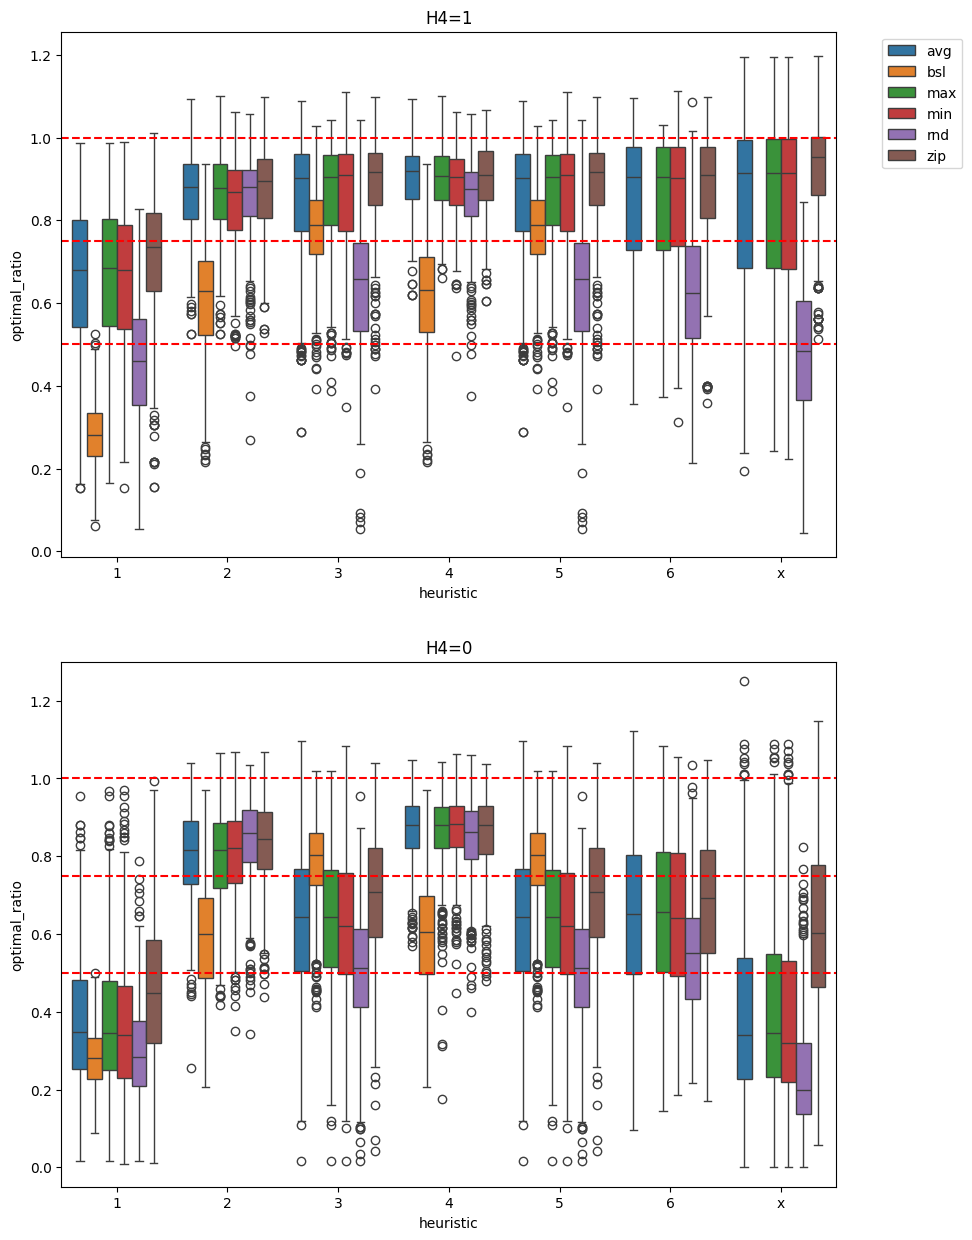

In [13]:
# from plot.plot_function import boxplot_plot
# boxplot
df = result_dict['combined']['balanced_df'].copy()
df = df.drop_duplicates()
##########################################  ##########################################
# RND - Shortest path          (RND - 1) #  # ZIP - Shortest path          (ZIP - 1) #
# RND - Lower bound            (RND - 2) #  # ZIP - Lower bound            (ZIP - 2) #
# RND - Upper bound            (RND - 3) #  # ZIP - Upper bound            (ZIP - 3) #
# RND - Adaptative lower bound (RND - 4) #  # ZIP - Adaptative lower bound (ZIP - 4) #
# RND - Adaptative upper bound (RND - 5) #  # ZIP - Adaptative upper bound (ZIP - 5) #
# RND - Comparative projection (RND - 6) #  # ZIP - Comparative projection (ZIP - 6) #
##########################################  ##########################################
 
##########################################  ##########################################
# MIN - Shortest path          (MIN - 1) #  # AVG - Shortest path          (AVG - 1) #
# MIN - Lower bound            (MIN - 2) #  # AVG - Lower bound            (AVG - 2) #
# MIN - Upper bound            (MIN - 3) #  # AVG - Upper bound            (AVG - 3) #
# MIN - Adaptative lower bound (MIN - 4) #  # AVG - Adaptative lower bound (AVG - 4) #
# MIN - Adaptative upper bound (MIN - 5) #  # AVG - Adaptative upper bound (AVG - 5) #
# MIN - Comparative projection (MIN - 6) #  # AVG - Comparative projection (AVG - 6) #
##########################################  ##########################################

                        ##########################################
                        # MAX - Shortest path          (MAX - 1) #
                        # MAX - Lower bound            (MAX - 2) #
                        # MAX - Upper bound            (MAX - 3) #
                        # MAX - Adaptative lower bound (MAX - 4) #
                        # MAX - Adaptative upper bound (MAX - 5) #
                        # MAX - Comparative projection (MAX - 6) #
                        ##########################################





fig, axs = plt.subplots(2, 1, figsize=(10, 15))
sns.boxplot(data=df[df['H4']==1], x="heuristic", y="optimal_ratio", hue="option",ax=axs[0])
axs[0].axhline(y=1, color='red', linestyle='--')
axs[0].axhline(y=0.75, color='red', linestyle='--')
axs[0].axhline(y=0.5, color='red', linestyle='--')
axs[0].set_title('H4=1')
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

sns.boxplot(data=df[df['H4']==0], x="heuristic", y="optimal_ratio", hue="option",ax=axs[1], legend=False)
axs[1].axhline(y=1, color='red', linestyle='--')
axs[1].axhline(y=0.75, color='red', linestyle='--')
axs[1].axhline(y=0.5, color='red', linestyle='--')
axs[1].set_title('H4=0')



# To set the x-axis range
# plt.xlim(xmin=0, xmax=6)
plt.ylim(ymin=-0.05, ymax=1.3)
plt.savefig('./result/2x6_boxplot_full.pdf')
plt.show()
plt.close()

In [92]:




# ###
# df = result_dict['combined']['balanced_df']



# # Create the subplots
# fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(35, 10))
# fig.subplots_adjust(left=0, right=0.95, bottom=0, top=1, wspace=0, hspace=0)
# def update_plot(opt_r):

#     cdt1 = (df['optimal_ratio']>=opt_r)
#     cdt2 = (df['heuristic']!='x')
#     data_df = df[ cdt1 & cdt2 ]

#     for ax in axs:
#         ax.clear()
#     # for i in range(axs.shape[0]):
#     #     for j in range(axs.shape[1]):
#     #         axs[i, j].clear()

    
#     # Plot 1
#     fracs = data_df['Class'].value_counts(normalize=True)
#     mask = fracs > 0.005
#     labels = fracs.index[mask]
#     sizes = fracs[mask]
#     colors = [class_color_map[label] for label in labels]
#     axs[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
#     axs[0].set_title('Parameter Distribution')
    
#     # Plot 2
#     fracs = data_df['option'].value_counts(normalize=True)
#     mask = fracs > 0.0005
#     labels = fracs.index[mask]
#     sizes = fracs[mask]
#     colors = [option_color_map[label] for label in labels]
#     axs[1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
#     axs[1].set_title('Option Distribution')

#     # Plot 3
#     fracs = data_df['heuristic'].value_counts(normalize=True)
#     mask = fracs > 0.0005
#     labels = fracs.index[mask]
#     sizes = fracs[mask]
#     colors = [heuristic_color_map[label] for label in labels]
#     axs[2].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
#     axs[2].set_title('Heuristic Distribution')
    
#     # Plot 1.1
#     fracs = data_df['pb_name'].value_counts(normalize=True)
#     mask = fracs > 0.005
#     labels = fracs.index[mask]
#     sizes = fracs[mask]
#     colors = [problem_color_map[label] for label in labels]
#     axs[3].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
#     axs[3].set_title('Problem Distribution')

#     # sns.histplot(data=data_df, x="adjusted_time_ratio", hue="heuristic", ax=axs[1,1])
#     # axs[1, 1].set_title('Adjusted Time Ratio Distribution by Heuristic')
    
#     # sns.histplot(data=data_df, x="adjusted_time_ratio", hue="option", ax=axs[1, 2])
#     # axs[1, 2].set_title('Adjusted Time Ratio Distribution by Option')
    
#     fig.suptitle(f'Distribution of Parameter, Option, and Heuristic when optimal ratio over {round(opt_r*100,2)}% (N={len(data_df)} of {len(df[df['heuristic']!='x'])})',
#                  y=0.97,  fontsize=16)


#     # if opt_r in [0.9, 0.95, 0.975]:
#     #     
# # Create the animation
# opt_r_values_1 = np.linspace(0.00, 0.9, 90)
# opt_r_values_2 = np.linspace(0.9, 1.0, 100)
# opt_r_values = np.concatenate([opt_r_values_1, opt_r_values_2])

# ani = animation.FuncAnimation(fig, update_plot, frames=opt_r_values, interval=500, blit=False)

# # Save the animation
# ani.save('movie.mp4', writer='ffmpeg', fps=10)

In [ ]:
# df = result_dict['combined']['meta_data_df']
# plot_kwargs = {
#                 'ticks_font_size':22,
#                 'label_font_size':24,
#                 'title_font_size':26,
#                 'legend_font_size':22,
#                 'fig_x_size':20,
#                 'fig_y_size':15,
#                 'x_label':'',
#                 'y_label':'',
#                 'title':'',
#               }

# plot_kwargs['title'] ='Correlation matrix'

# cdt1 = (df['max_sl']!=0)
# cdt2 = (df['m']!=0)

# cdt3 = (df['option']=='rnd')
# cdt4 = (df['option']=='zip')
# cdt5 = (df['option']=='min')

# cdt6 = (df['heuristic']=='1')
# cdt10 = (df['heuristic']=='2')
# cdt11 = (df['heuristic']=='3')
# cdt7 = (df['heuristic']=='4')
# cdt8 = (df['heuristic']=='5')
# cdt9 = (df['heuristic']=='x')



# conditions = []
# params = []

# # rnd-1
# conditions.append((cdt1 & cdt2 & cdt3 & cdt6))
# params.append('RND-1')
# # rnd-2
# conditions.append((cdt1 & cdt2 & cdt3 & cdt10))
# params.append('RND-2')
# # rnd-3
# conditions.append((cdt1 & cdt2 & cdt3 & cdt11))
# params.append('RND-3')
# # rnd-4
# conditions.append((cdt1 & cdt2 & cdt3 & cdt7))
# params.append('RND-4')
# # rnd-5
# conditions.append((cdt1 & cdt2 & cdt3 & cdt8))
# params.append('RND-5')

# # zip-1
# conditions.append((cdt1 & cdt2 & cdt4 & cdt6))
# params.append('ZIP-1')
# # zip-2
# conditions.append((cdt1 & cdt2 & cdt4 & cdt10))
# params.append('ZIP-2')
# # zip-3
# conditions.append((cdt1 & cdt2 & cdt4 & cdt11))
# params.append('ZIP-3')
# # zip-4
# conditions.append((cdt1 & cdt2 & cdt4 & cdt7))
# params.append('ZIP-4')
# # zip-5
# conditions.append((cdt1 & cdt2 & cdt4 & cdt8))
# params.append('ZIP-5')

# # min-1
# conditions.append((cdt1 & cdt2 & cdt5 & cdt6))
# params.append('MIN-1')
# # min-2
# conditions.append((cdt1 & cdt2 & cdt5 & cdt10))
# params.append('MIN-2')
# # min-3
# conditions.append((cdt1 & cdt2 & cdt5 & cdt11))
# params.append('MIN-3')
# # min-4
# conditions.append((cdt1 & cdt2 & cdt5 & cdt7))
# params.append('MIN-4')
# # min-5
# conditions.append((cdt1 & cdt2 & cdt5 & cdt8))
# params.append('MIN-5')

# # rdn-x
# conditions.append((cdt1 & cdt2 & cdt3 & cdt9))
# params.append('RDN-x')
# # zip-x
# conditions.append((cdt1 & cdt2 & cdt4 & cdt9))
# params.append('ZIP-x')
# # min-x
# conditions.append((cdt1 & cdt2 & cdt5 & cdt9))
# params.append('MIN-x')


# fig, axs = plt.subplots(4, 5, figsize=(60, 60))
# plot_kwargs['fig'] = fig
# j= [0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3]

# for i, (condition, param) in enumerate(zip(conditions, params)):
#     data = df[condition]
#     plot_kwargs['title'] = param
#     plot_kwargs['ax'] = axs[j[i], i%5]
#     p = correlation_matrix(data, columns=['optimal_ratio', 'time_ratio', 'tolled_ratio', 'H4', 'min_sl', 'max_sl', 'm'],  **plot_kwargs)

# plt.savefig('./result/conf_matrix_9.pdf')
# plt.show()
# plt.close()


In [ ]:
# sns.set(style='darkgrid')

# plot_kwargs = {
#                 'ticks_font_size':22,
#                 'label_font_size':24,
#                 'title_font_size':26,
#                 'legend_font_size':22,
#                 'fig_x_size':15,
#                 'fig_y_size':10,
#                 'x_label':'',
#                 'y_label':'',
#                 'title':'',
#               }


# # p = edge_edge_variance_histplot(edge_value_df,problem_name,**plot_kwargs)
# # plt.show()
# # p = edge_edge_mean_histplot(edge_value_df,problem_name,**plot_kwargs)
# # plt.show()
# # p = flow_flow_variance_histplot(flow_value_df,problem_name,**plot_kwargs)
# # plt.show()
# # p = flow_flow_mean_histplot(flow_value_df,problem_name,**plot_kwargs)
# # plt.show()
# # p = objective_objective_histplot(meta_data_df,problem_name,**plot_kwargs)
# # plt.show()
# # p = time_histplot(meta_data_df,problem_name,**plot_kwargs)
# # plt.show()

# #######################
# # The big picture
# ######################

# df = result_dict['combined']['meta_data_df']

# cdt1 = (df['time_ratio']<=5)

# cdt2 = (df['H4']==1)
# notcdt2 = (df['H4']==0)

# cdt3 = (df['m']!=0)
# notcdt3 = (df['m']==0)

# cdt4 = (df['max_sl']!=0)
# notcdt4 = (df['max_sl']==0)

# cdt5 = (df['option']=='rnd')
# cdt6 = (df['option']=='zip')
# cdt7 = (df['option']=='min')

# cdt8 = (df['heuristic']=='x')
# cdt9 = (df['heuristic']=='1')
# cdt12 = (df['heuristic']=='2')
# cdt13 = (df['heuristic']=='3')
# cdt10 = (df['heuristic']=='4')
# cdt11 = (df['heuristic']=='5')






# conditions = []
# params = []

# ### H=1, m!=0, max_sl!=0
# # ####################################################################################################################
# # conditions.append((cdt1 & cdt2 & cdt3 & cdt4 & cdt5 & cdt8))
# # params.append('(H4=1, m!=0, max_sl!=0, RDN-x)')
# # ####################################################################################################################
# # conditions.append((cdt1 & cdt2 & cdt3 & cdt4 & cdt6 & cdt8))
# # params.append('(H4=1, m!=0, max_sl!=0, ZIP-x)')
# # ####################################################################################################################
# # conditions.append((cdt1 & cdt2 & cdt3 & cdt4 & cdt7 & cdt8))
# # params.append('(H4=1, m!=0, max_sl!=0, MIN-x)')
# # ####################################################################################################################

# ####################################################################################################################
# conditions.append((cdt1 & cdt2 & cdt3 & cdt4 & cdt5 & cdt9))
# params.append('(H4=1, m!=0, max_sl!=0, RDN-1)')
# ####################################################################################################################
# conditions.append((cdt1 & cdt2 & cdt3 & cdt4 & cdt6 & cdt9))
# params.append('(H4=1, m!=0, max_sl!=0, ZIP-1)')
# ####################################################################################################################
# conditions.append((cdt1 & cdt2 & cdt3 & cdt4 & cdt7 & cdt9))
# params.append('(H4=1, m!=0, max_sl!=0, MIN-1)')
# ####################################################################################################################

# ####################################################################################################################
# conditions.append((cdt1 & cdt2 & cdt3 & cdt4 & cdt5 & cdt12))
# params.append('(H4=1, m!=0, max_sl!=0, RDN-2)')
# ####################################################################################################################
# conditions.append((cdt1 & cdt2 & cdt3 & cdt4 & cdt6 & cdt12))
# params.append('(H4=1, m!=0, max_sl!=0, ZIP-2)')
# ####################################################################################################################
# conditions.append((cdt1 & cdt2 & cdt3 & cdt4 & cdt7 & cdt12))
# params.append('(H4=1, m!=0, max_sl!=0, MIN-2)')
# ####################################################################################################################

# ####################################################################################################################
# conditions.append((cdt1 & cdt2 & cdt3 & cdt4 & cdt5 & cdt13))
# params.append('(H4=1, m!=0, max_sl!=0, RDN-3)')
# ####################################################################################################################
# conditions.append((cdt1 & cdt2 & cdt3 & cdt4 & cdt6 & cdt13))
# params.append('(H4=1, m!=0, max_sl!=0, ZIP-3)')
# ####################################################################################################################
# conditions.append((cdt1 & cdt2 & cdt3 & cdt4 & cdt7 & cdt13))
# params.append('(H4=1, m!=0, max_sl!=0, MIN-3)')
# ####################################################################################################################

# ####################################################################################################################
# conditions.append((cdt1 & cdt2 & cdt3 & cdt4 & cdt5 & cdt10))
# params.append('(H4=1, m!=0, max_sl!=0, RDN-4)')
# ####################################################################################################################
# conditions.append((cdt1 & cdt2 & cdt3 & cdt4 & cdt6 & cdt10))
# params.append('(H4=1, m!=0, max_sl!=0, ZIP-4)')
# ####################################################################################################################
# conditions.append((cdt1 & cdt2 & cdt3 & cdt4 & cdt7 & cdt10))
# params.append('(H4=1, m!=0, max_sl!=0, MIN-4)')
# ####################################################################################################################

# ####################################################################################################################
# conditions.append((cdt1 & cdt2 & cdt3 & cdt4 & cdt5 & cdt11))
# params.append('(H4=1, m!=0, max_sl!=0, RDN-5)')
# ####################################################################################################################
# conditions.append((cdt1 & cdt2 & cdt3 & cdt4 & cdt6 & cdt11))
# params.append('(H4=1, m!=0, max_sl!=0, ZIP-5)')
# ####################################################################################################################
# conditions.append((cdt1 & cdt2 & cdt3 & cdt4 & cdt7 & cdt11))
# params.append('(H4=1, m!=0, max_sl!=0, MIN-5)')
# ####################################################################################################################

# ### H=0, m!=0, max_sl!=0
# # ####################################################################################################################
# # conditions.append((cdt1 & notcdt2 & cdt3 & cdt4 & cdt5 & cdt8))
# # params.append('(H4=0, m!=0, max_sl!=0, RDN-x)')
# # ####################################################################################################################
# # conditions.append((cdt1 & notcdt2 & cdt3 & cdt4 & cdt6 & cdt8))
# # params.append('(H4=0, m!=0, max_sl!=0, ZIP-x)')
# # ####################################################################################################################
# # conditions.append((cdt1 & notcdt2 & cdt3 & cdt4 & cdt7 & cdt8))
# # params.append('(H4=0, m!=0, max_sl!=0, MIN-x)')
# # ####################################################################################################################

# ####################################################################################################################
# conditions.append((cdt1 & notcdt2 & cdt3 & cdt4 & cdt5 & cdt9))
# params.append('(H4=0, m!=0, max_sl!=0, RDN-1)')
# ####################################################################################################################
# conditions.append((cdt1 & notcdt2 & cdt3 & cdt4 & cdt6 & cdt9))
# params.append('(H4=0, m!=0, max_sl!=0, ZIP-1)')
# ####################################################################################################################
# conditions.append((cdt1 & notcdt2 & cdt3 & cdt4 & cdt7 & cdt9))
# params.append('(H4=0, m!=0, max_sl!=0, MIN-1)')
# ####################################################################################################################

# ####################################################################################################################
# conditions.append((cdt1 & notcdt2 & cdt3 & cdt4 & cdt5 & cdt12))
# params.append('(H4=0, m!=0, max_sl!=0, RDN-2)')
# ####################################################################################################################
# conditions.append((cdt1 & notcdt2 & cdt3 & cdt4 & cdt6 & cdt12))
# params.append('(H4=0, m!=0, max_sl!=0, ZIP-2)')
# ####################################################################################################################
# conditions.append((cdt1 & notcdt2 & cdt3 & cdt4 & cdt7 & cdt12))
# params.append('(H4=0, m!=0, max_sl!=0, MIN-2)')
# ####################################################################################################################

# ####################################################################################################################
# conditions.append((cdt1 & notcdt2 & cdt3 & cdt4 & cdt5 & cdt13))
# params.append('(H4=0, m!=0, max_sl!=0, RDN-3)')
# ####################################################################################################################
# conditions.append((cdt1 & notcdt2 & cdt3 & cdt4 & cdt6 & cdt13))
# params.append('(H4=0, m!=0, max_sl!=0, ZIP-3)')
# ####################################################################################################################
# conditions.append((cdt1 & notcdt2 & cdt3 & cdt4 & cdt7 & cdt13))
# params.append('(H4=0, m!=0, max_sl!=0, MIN-3)')
# ####################################################################################################################

# ####################################################################################################################
# conditions.append((cdt1 & notcdt2 & cdt3 & cdt4 & cdt5 & cdt10))
# params.append('(H4=0, m!=0, max_sl!=0, RDN-4)')
# ####################################################################################################################
# conditions.append((cdt1 & notcdt2 & cdt3 & cdt4 & cdt6 & cdt10))
# params.append('(H4=0, m!=0, max_sl!=0, ZIP-4)')
# ####################################################################################################################
# conditions.append((cdt1 & notcdt2 & cdt3 & cdt4 & cdt7 & cdt10))
# params.append('(H4=0, m!=0, max_sl!=0, MIN-4)')
# ####################################################################################################################

# ####################################################################################################################
# conditions.append((cdt1 & notcdt2 & cdt3 & cdt4 & cdt5 & cdt11))
# params.append('(H4=0, m!=0, max_sl!=0, RDN-5)')
# ####################################################################################################################
# conditions.append((cdt1 & notcdt2 & cdt3 & cdt4 & cdt6 & cdt11))
# params.append('(H4=0, m!=0, max_sl!=0, ZIP-5)')
# ####################################################################################################################
# conditions.append((cdt1 & notcdt2 & cdt3 & cdt4 & cdt7 & cdt11))
# params.append('(H4=0, m!=0, max_sl!=0, MIN-5)')
# ####################################################################################################################




# ### H=1, m=0, max_sl=0
# ####################################################################################################################
# conditions.append((cdt1 & cdt2 & notcdt3 & notcdt4))
# params.append('(H4=1, m=0, max_sl=0)')
# ####################################################################################################################
# ### H=0, m=0, max_sl=0
# ####################################################################################################################
# conditions.append((cdt1 & notcdt2 & notcdt3 & notcdt4))
# params.append('(H4=1, m=0, max_sl=0)')


# fig, axs = plt.subplots(len(params), 3, figsize=(70, len(params)*12))  # Create a 2x2 grid of subplots

# for i, (condition, param) in enumerate(zip(conditions, params)):
#     data = df[condition]
#     if param in ['(H4=1, m=0, max_sl=0)', '(H4=1, m=0, max_sl=0)']:
#         yy = 'Class2'
#     else:
#         yy = 'Class'

    
#     # Optimal ratio
#     plot_kwargs['xrange'] = (-0.05, 1.2)
#     plot_kwargs['title'] = f'Optimal ratio {param}'
#     plot_kwargs['x_label'] = 'Optimal ratio'
#     plot_kwargs['ax'] = axs[i, 0]
#     plot_kwargs['fig'] = fig
#     p = boxplot_plot(data, x_='optimal_ratio', yclass_=yy, crosshairs=(1,), legend=False, **plot_kwargs)
    
#     # Time ratio
#     plot_kwargs['title'] = f'Adjusted time ratio {param}'
#     plot_kwargs['x_label'] = 'Adjusted time ratio'
#     plot_kwargs['xrange'] = (-0.05, 2)
#     plot_kwargs['ax'] = axs[i, 1]
#     p = boxplot_plot(data, x_='adjusted_time_ratio', yclass_=yy, crosshairs=(1,), legend=False, **plot_kwargs)
    
#     # Edge difference mean 
#     plot_kwargs['xrange'] = ()
#     plot_kwargs['title'] = f'Edge difference mean {param}'
#     plot_kwargs['x_label'] = 'Edge difference mean'
#     plot_kwargs['ax'] = axs[i, 2]
#     p = boxplot_plot(data, x_='edge_diff_mean', yclass_=yy, crosshairs=(0,), legend=True, **plot_kwargs)

    
#     # # Optimal ratio rewind 1
#     # plot_kwargs['title'] = f'Optimal gap (rewind 1) {param}'
#     # plot_kwargs['x_label'] = 'Optimal gap'
#     # plot_kwargs['ax'] = axs[i, 3]
#     # p = boxplot_plot(data, x_='optimal_ratio_rewind_1', crosshairs=(1,), legend=False, **plot_kwargs)
    
#     # # Optimal ratio rewind 2
#     # plot_kwargs['title'] = f'Optimal gap (rewind 2) {param}'
#     # plot_kwargs['x_label'] = 'Optimal gap'
#     # plot_kwargs['ax'] = axs[i, 4]
#     # p = boxplot_plot(data, x_='optimal_ratio_rewind_2', crosshairs=(1,), legend=False, **plot_kwargs)


# plt.savefig('./result/16plot.pdf')
# plt.show()
# plt.close()

# ######################
# # Optimal ratio rewind 1
# # data = merged_df[conditions[0]]
# # plot_kwargs['title'] = f'Optimal gap with locality'
# # plot_kwargs['x_label'] = r'Optimal gap ($\tilde{x}^* / x^*$)'
# # plot_kwargs['ax'] = False
# # plot_kwargs['fig']=False
# # p = boxplot_plot(data, x_='optimal_ratio_rewind_1', crosshairs=(1,), legend=True, **plot_kwargs)
# # plt.savefig('./result/box_plot_optimal_gap_h4_1.pdf')
# # plt.close()

# # plot_kwargs['title'] = f'Time ratio with locality'
# # plot_kwargs['x_label'] = r'Time ratio ($\widetilde{T}/T$)'
# # plot_kwargs['ax'] = False
# # plot_kwargs['fig']=False
# # p = boxplot_plot(data, x_='time_ratio_rewind_1', crosshairs=(1,), legend=True, **plot_kwargs)
# # plt.savefig('./result/box_plot_time_ratio_h4_1.pdf')
# # plt.close()

# # data = merged_df[conditions[1]]
# # plot_kwargs['title'] = f'Optimal gap without locality'
# # plot_kwargs['x_label'] = r'Optimal gap ($\tilde{x}^* / x^*$)'
# # plot_kwargs['ax'] = False
# # plot_kwargs['fig']=False
# # p = boxplot_plot(data, x_='optimal_ratio_rewind_1', crosshairs=(1,), legend=True, **plot_kwargs)
# # plt.savefig('./result/box_plot_optimal_gap_h4_0.pdf')
# # plt.close()

# # plot_kwargs['title'] = f'Time ratio without locality'
# # plot_kwargs['x_label'] = r'Time ratio ($\widetilde{T}/T$)'
# # plot_kwargs['ax'] = False
# # plot_kwargs['fig']= False
# # p = boxplot_plot(data, x_='time_ratio_rewind_1', crosshairs=(1,), legend=True, **plot_kwargs)
# # plt.savefig('./result/box_plot_time_ratio_h4_0.pdf')
# # plt.close()